In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

The dataset will be working on is made of measurements made on a water distribution system in Germany. The data was collected from sensors on a minutely basis. Below are detailled the water quality indicators, and **<font color=#ff7400>any changes are considered as events (anomalies)</font>**. 

But, it is important to note that the **<font color=#ff7400>flow rate and the temperature</font>** of the water is considered as operational data: **<font color=#ff7400>changes</font>** in these values may indicate variations in the related quality values but **<font color=#ff7400>are not considered as events themselves</font>**.

Here are more details about the dataset columns:

- Time: Time of measurement, given in following format: yyyy-mm-dd HH:MM:SS 
- Tp: The temperature of the water, given in °C.
- Cl: Amount of chlorine dioxide in the water, given in mg/L (MS1)
- pH: PH value of the water
- Redox: Redox potential, given in mV
- Leit: Electric conductivity of the water, given in μS/cm
- Trueb: Turbidity of the water, given in NTU
- Cl_2: Amount of chlorine dioxide in the water, given in mg/L (MS2)
- Fm: Flow rate at water line 1, given in m3/h
- Fm_2: Flow rate at water line 2, given in m3/h
- EVENT: Marker if this entry should be considered as a remarkable change resp. event, given in boolean.

Dataset with more detailled information are available [here](https://www.spotseven.de/gecco/gecco-challenge/gecco-challenge-2018/).

Let's start with an overview of the dataset:

In [2]:
data_path = "../data/raw/waterDataTraining.csv"
df = pd.read_csv(data_path)
df.head(5)

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03T09:49:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03T09:50:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03T09:51:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03T09:52:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03T09:53:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139566 entries, 0 to 139565
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    139566 non-null  object 
 1   Tp      138522 non-null  float64
 2   Cl      138521 non-null  float64
 3   pH      138522 non-null  float64
 4   Redox   138522 non-null  float64
 5   Leit    138522 non-null  float64
 6   Trueb   138522 non-null  float64
 7   Cl_2    138522 non-null  float64
 8   Fm      138522 non-null  float64
 9   Fm_2    138522 non-null  float64
 10  EVENT   139566 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 10.8+ MB


At first sight, it seems we have some null values, as some rows count are not equal to the total number of rows. Let's investigate further:

In [4]:
df.isnull().sum()

Time        0
Tp       1044
Cl       1045
pH       1044
Redox    1044
Leit     1044
Trueb    1044
Cl_2     1044
Fm       1044
Fm_2     1044
EVENT       0
dtype: int64

In [5]:
null_data = df[df.isnull().any(axis=1)]
null_data.head()

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
37152,2016-08-29T05:01:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
37153,2016-08-29T05:02:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
37154,2016-08-29T05:03:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
37155,2016-08-29T05:04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
37156,2016-08-29T05:05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [6]:
null_data.tail()

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
126221,2016-10-30T01:30:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
126222,2016-10-30T01:31:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
126223,2016-10-30T01:32:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
126224,2016-10-30T01:33:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
126225,2016-10-30T01:34:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [7]:
(df.isnull().sum()[1] / df.shape[0])*100

/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_7116/3524272453.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.isnull().sum()[1] / df.shape[0])*100


0.7480331885989424

As we can see, missing values for all columns are always on the same rows (except for one) and count for 0.7% of the data. Therefore, we will probably drop those rows when building the model.

# Features over Time

In this section we will try to plot every features with "Time" as the x axis. It might help us to detect any trend in the data and maybe to build some intuitions of when are anomalies taking place.

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.columns

Index(['Time', 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm',
       'Fm_2', 'EVENT'],
      dtype='object')

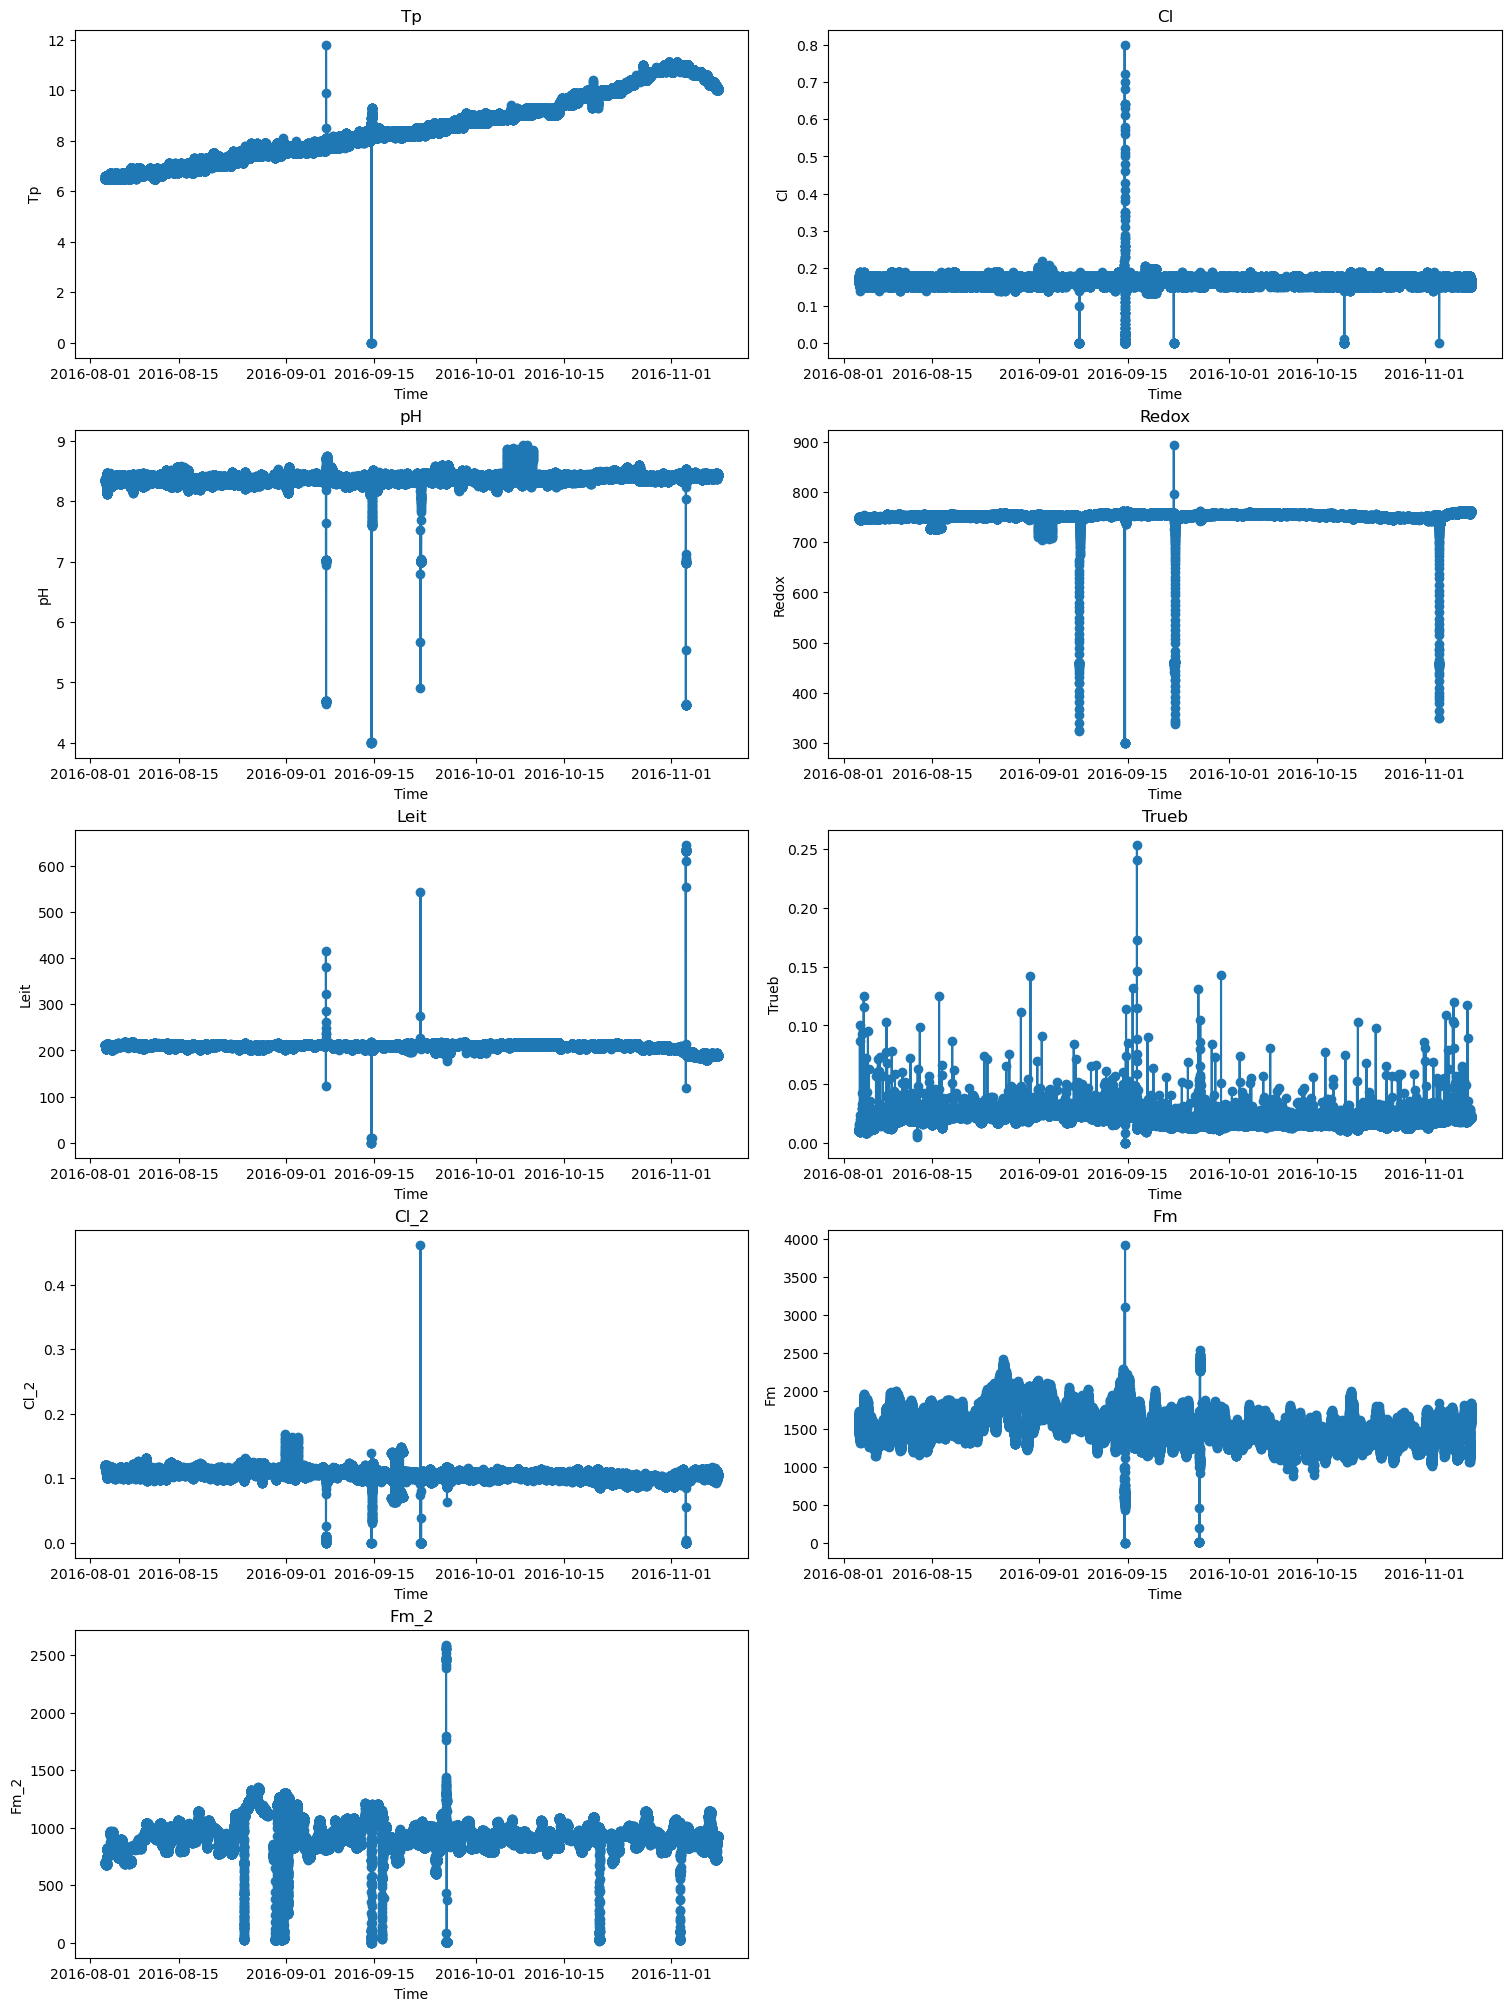

In [10]:
columns_to_plot = df.columns[1:-1]

n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    axes[i].plot(df['Time'], df[col], marker='o', linestyle='-')
    axes[i].set_title(col)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(col)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.show()

As we can see, most of our features design straight lines over time. However, for some, we can observe values far from the rest of the data points. This is especially true for Temperature for example. However, as we stated at the beginning, Temperature and Flow Rate are not considered as good indicators for anomaly detection. 

Therefore, we will focus on other features and plot them again, but this time by highlighting the anomalies.

# Anomalies Investigation

### 1. Casting labels as 1 (anomaly) or 0 (no anomaly)

In [11]:
df["EVENT"] = np.where(df["EVENT"] == False, 0, 1)

In [12]:
df.head()

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03 09:49:00+00:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,2016-08-03 09:50:00+00:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,2016-08-03 09:51:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,2016-08-03 09:52:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,2016-08-03 09:53:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


### 2. Counting Anomalies Repartition

In [13]:
anomalies = df.groupby(["EVENT"]).size()
anomalies

EVENT
0    137840
1      1726
dtype: int64

In [14]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\nOut of {df.shape[0]} rows, {anomalies[1]} rows are anomalies, counting for {round((anomalies[1] / df.shape[0])*100, 2)}% of the data.")

Dataset contains 139566 rows and 11 columns.
Out of 139566 rows, 1726 rows are anomalies, counting for 1.24% of the data.


As we can see, anomalies only represent a very small part of our dataset by representing less than 2% of the whole data.

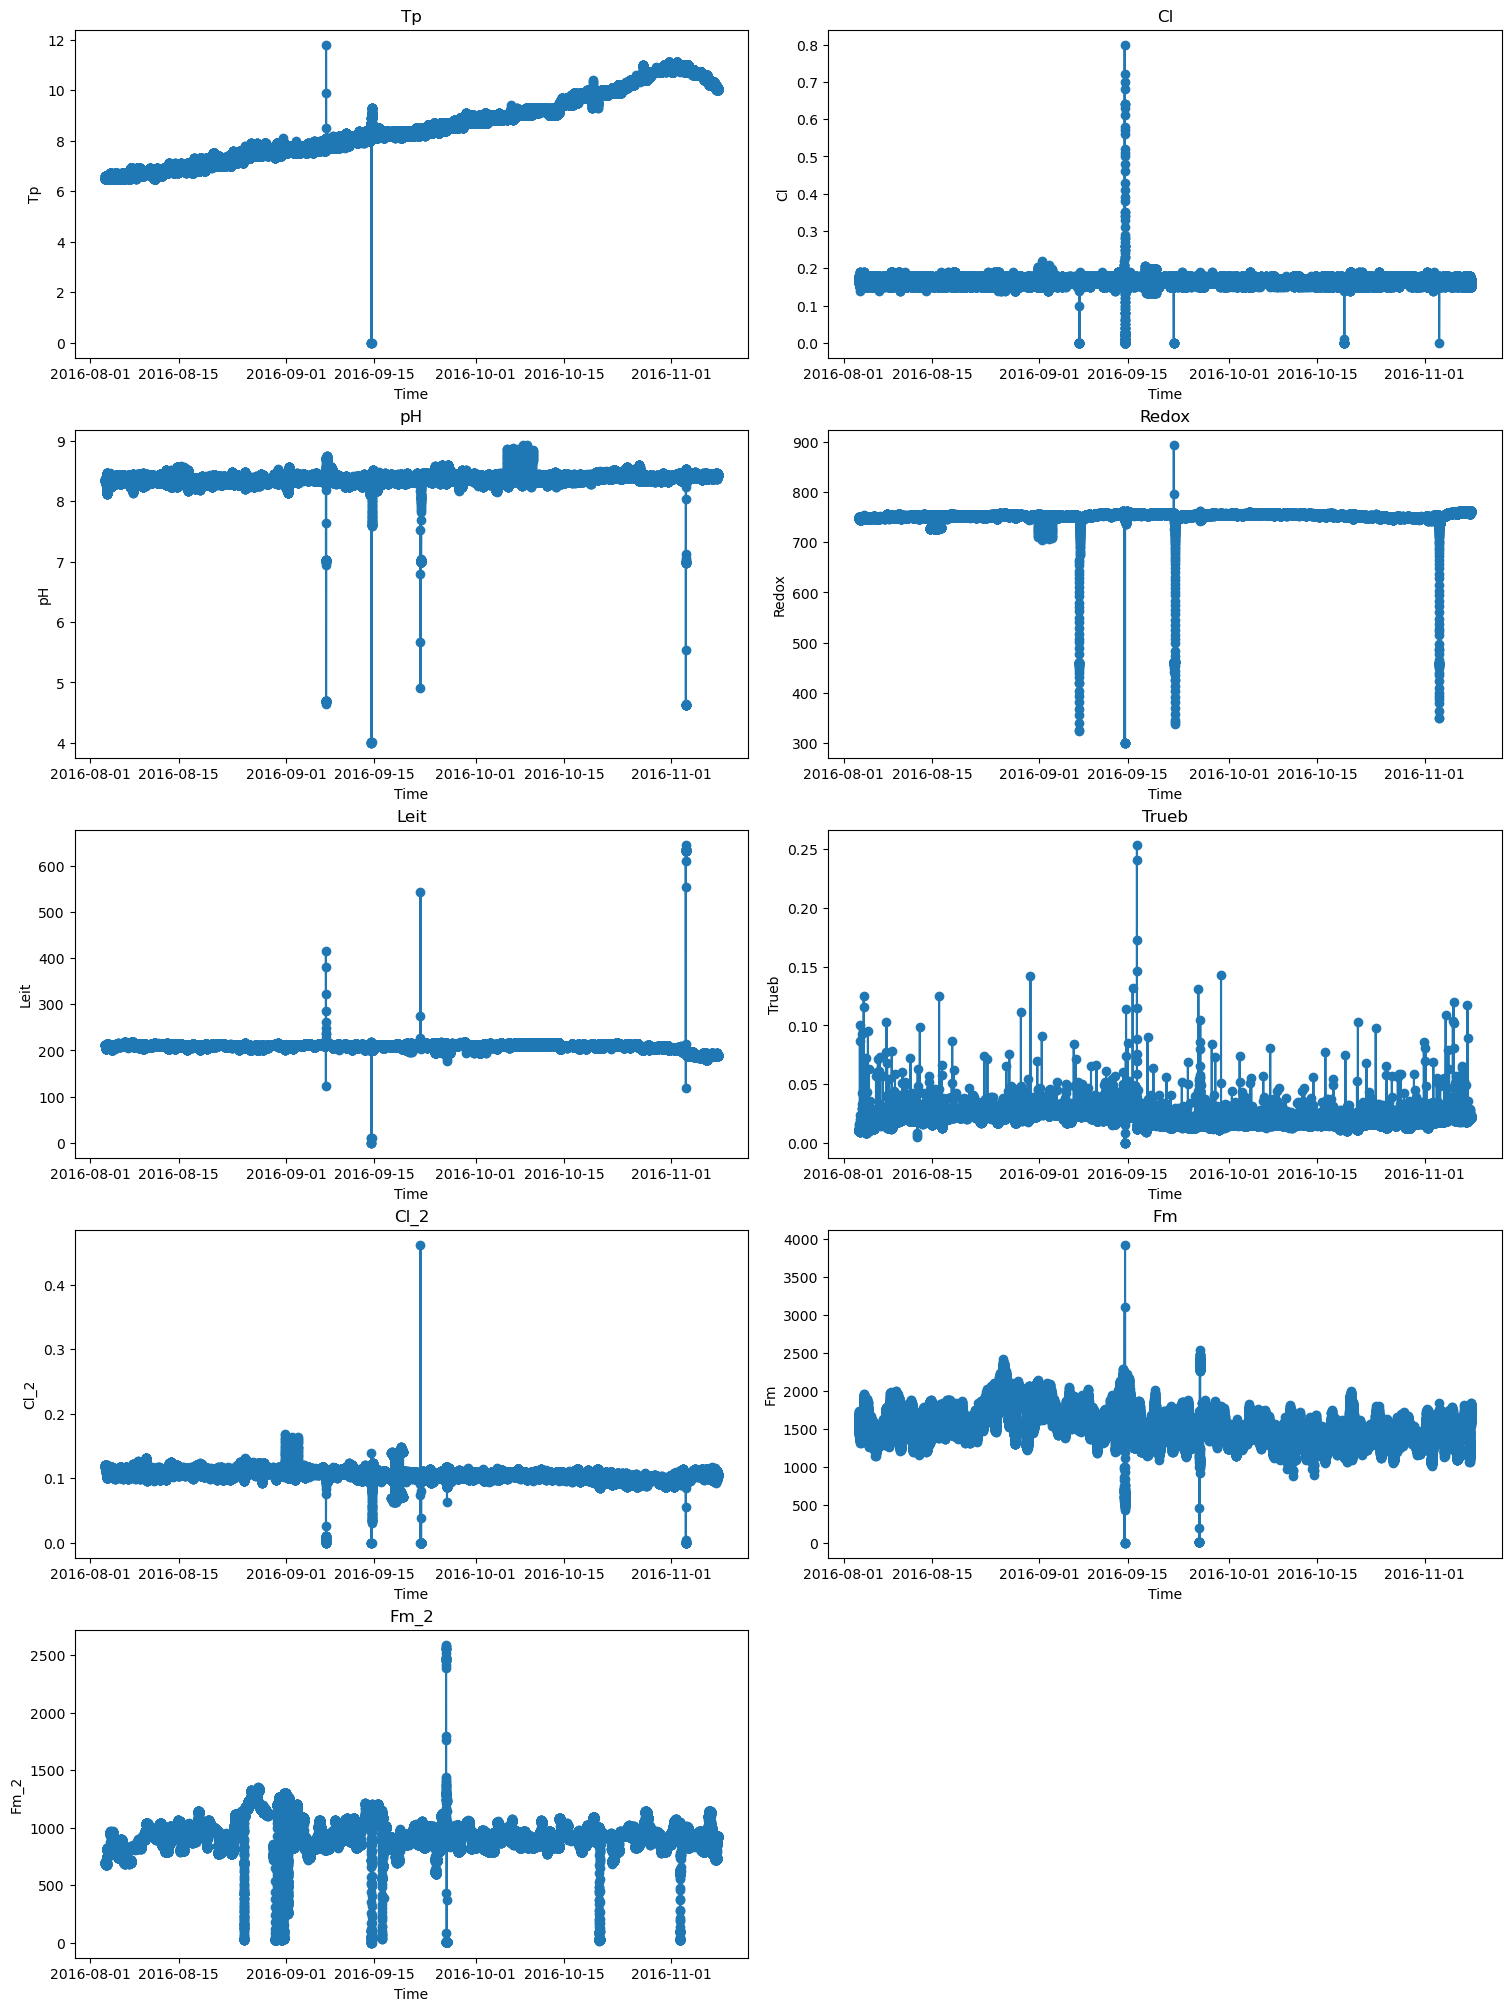

In [15]:
columns_to_plot = df.columns[1:-1]

n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    axes[i].plot(df['Time'], df[col], marker='o', linestyle='-')
    axes[i].set_title(col)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(col)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.show()

In [16]:
df.columns

Index(['Time', 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm',
       'Fm_2', 'EVENT'],
      dtype='object')

In [17]:
columns_to_plot = list(df.columns)
to_remove = ["Time", "Tp", "Fm", "Fm_2", "EVENT"]
for col in to_remove:   
    columns_to_plot.remove(col)

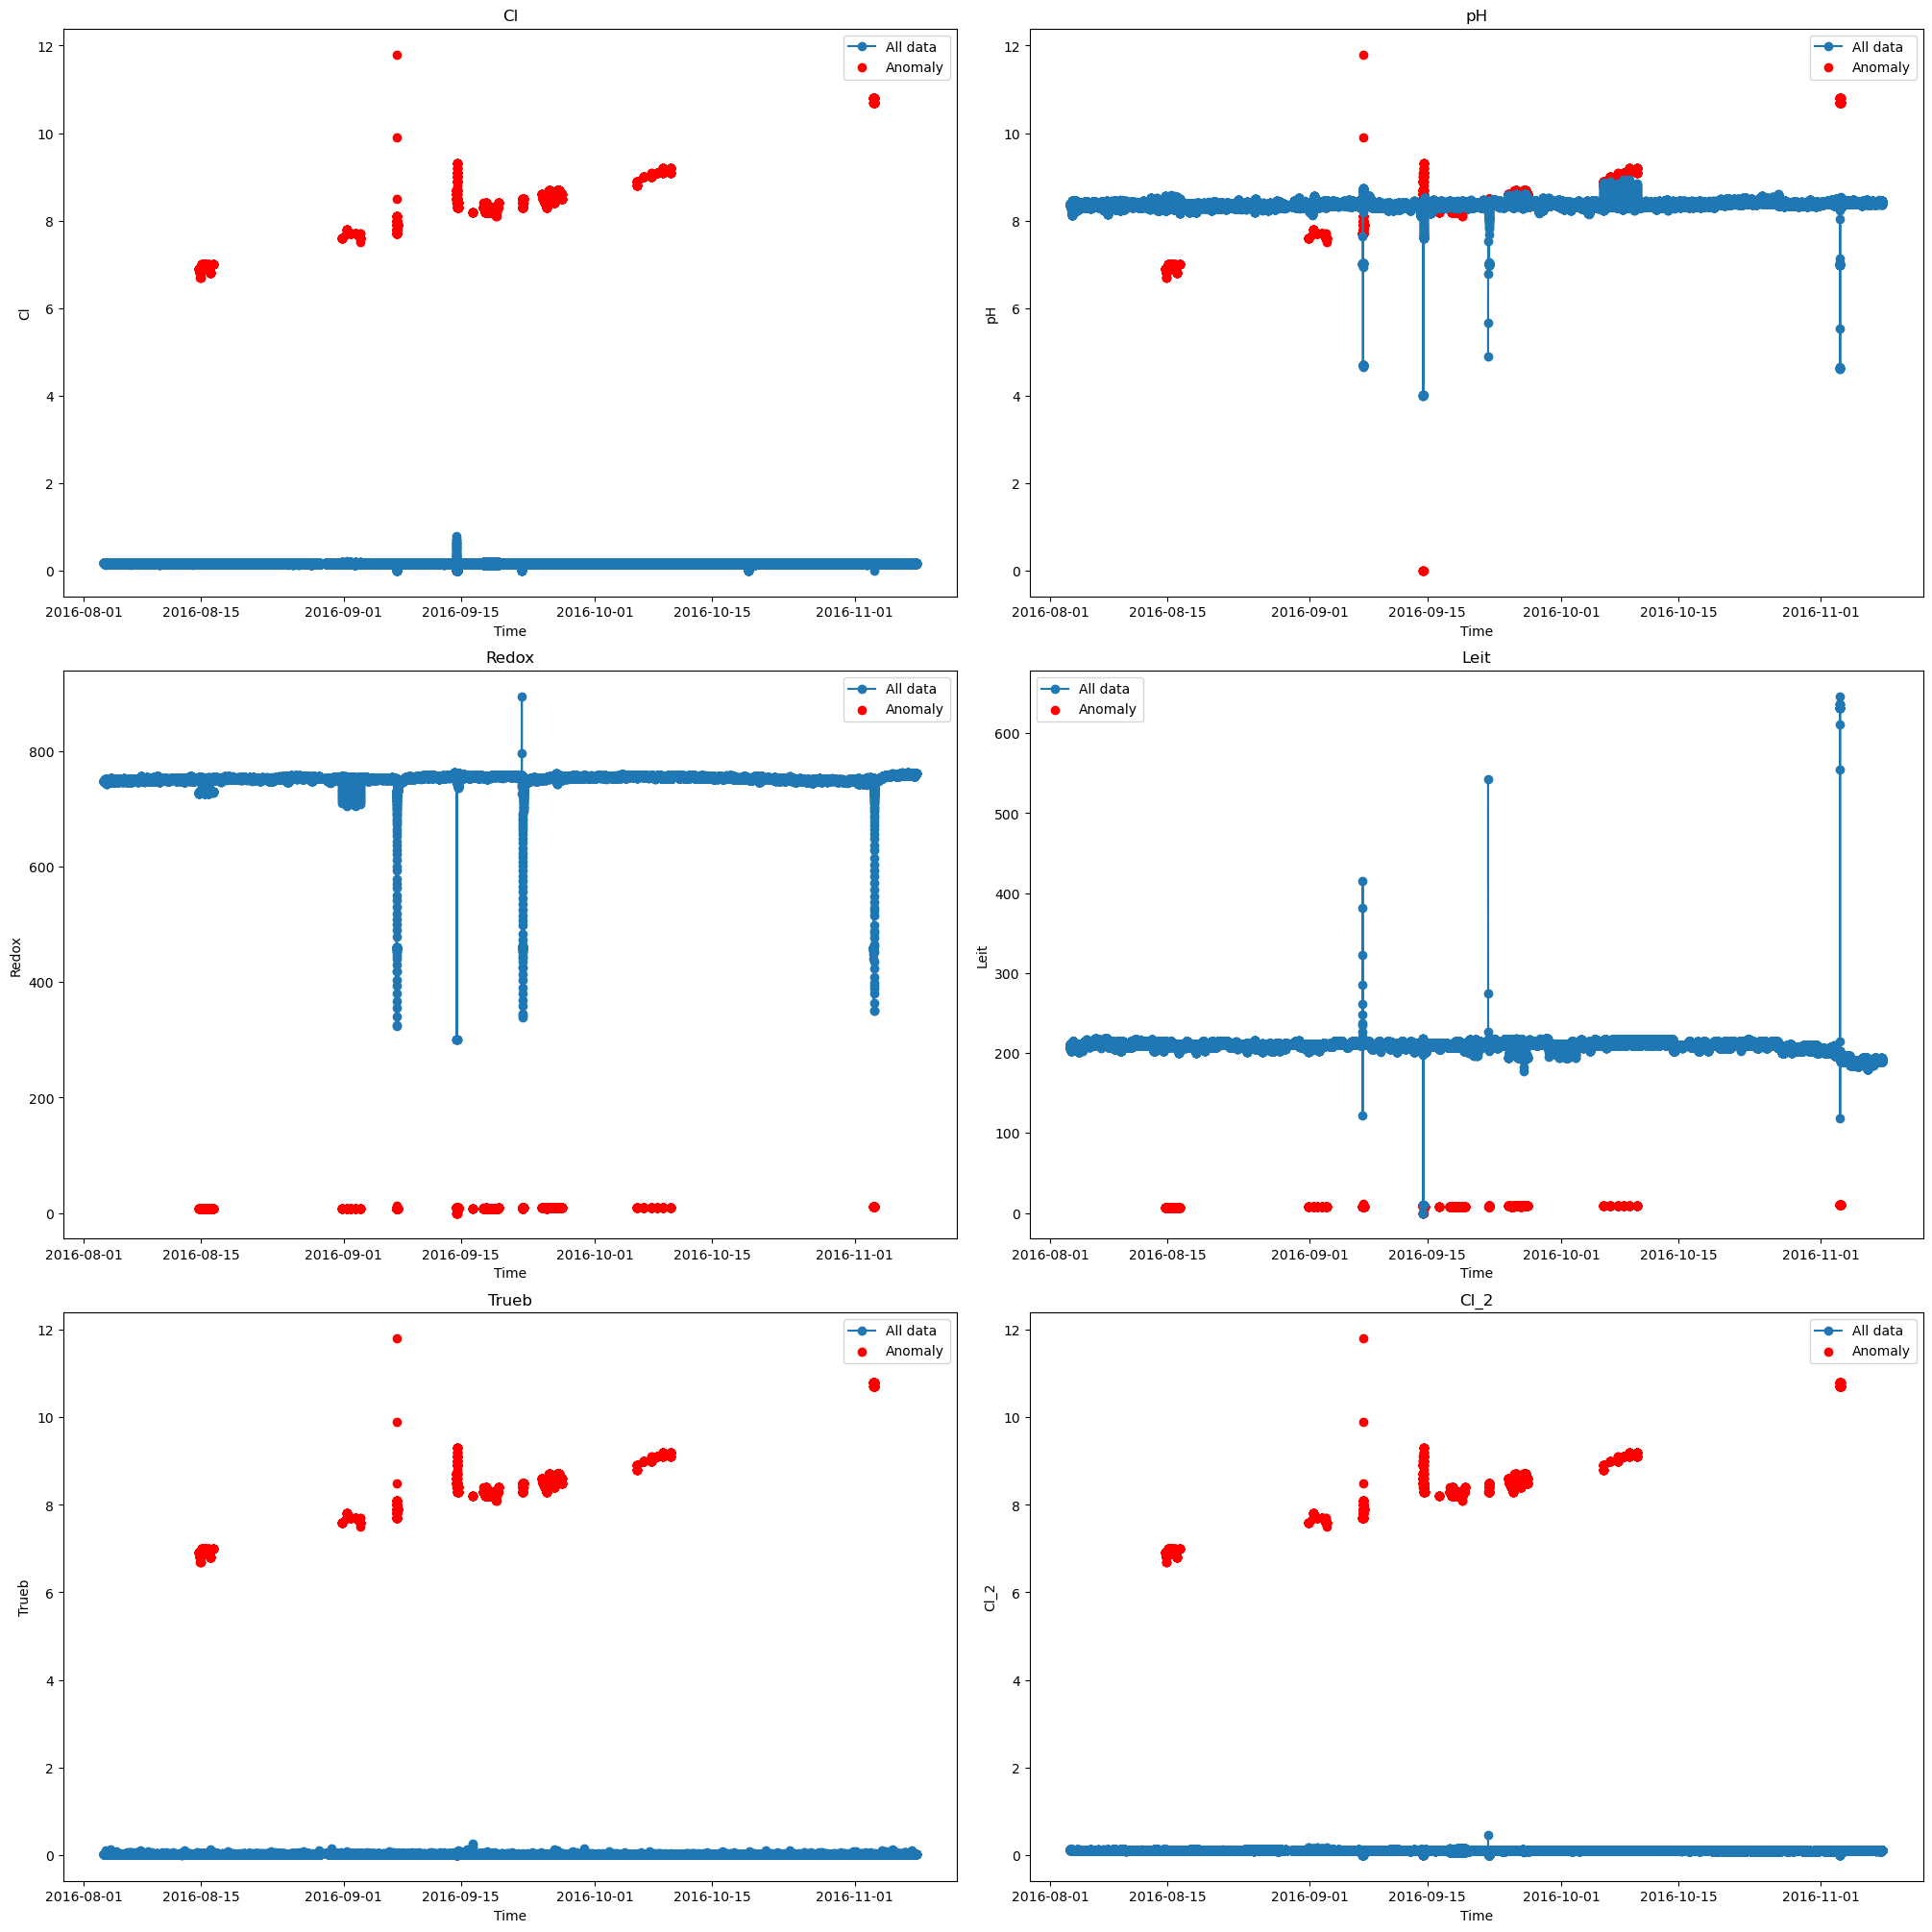

In [18]:
n_cols = 2
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols
anomalies = df[df['EVENT'] == 1]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    axes[i].plot(df['Time'], df[col], marker='o', linestyle='-', label='All data')
    axes[i].scatter(anomalies['Time'], anomalies['Tp'], color='red', label='Anomaly') # Highlighting points where EVENT == 1
    axes[i].set_title(col)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(col)
    axes[i].legend()

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.show()

With those graphs, it seems most of the anomalies are outliers. To be sure, we plotted below the features one by one, so we can have a better scale. After analysis, we can se that if some anomalies are real outliers, many of them are still "mixed in the crowd" and detecting them might not be that easy.

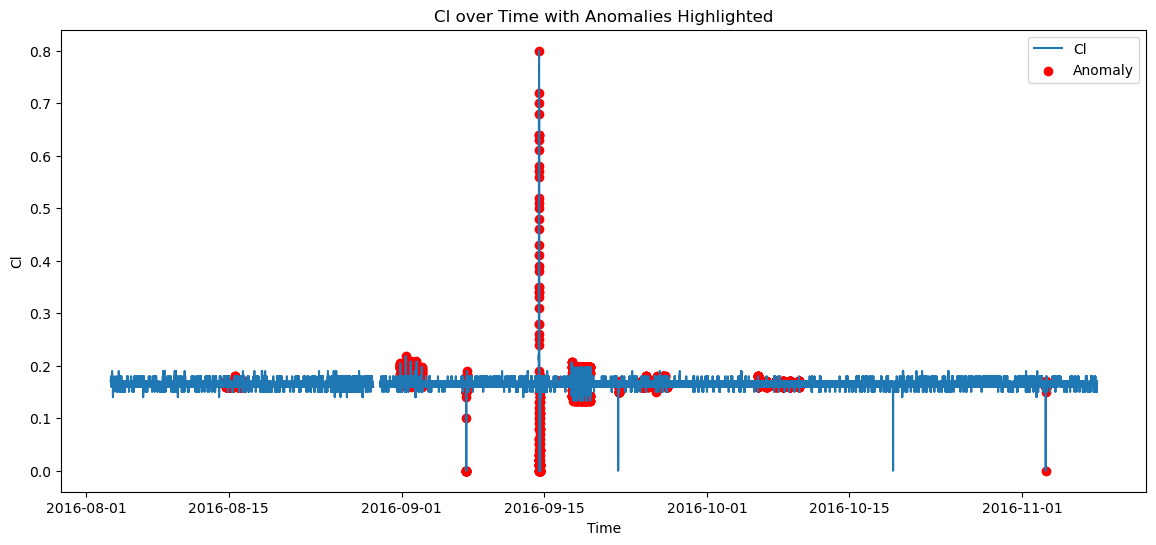

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Cl'], label='Cl')
plt.scatter(anomalies['Time'], anomalies['Cl'], color='red', label='Anomaly')
plt.title('Cl over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Cl')
plt.legend()
plt.show()

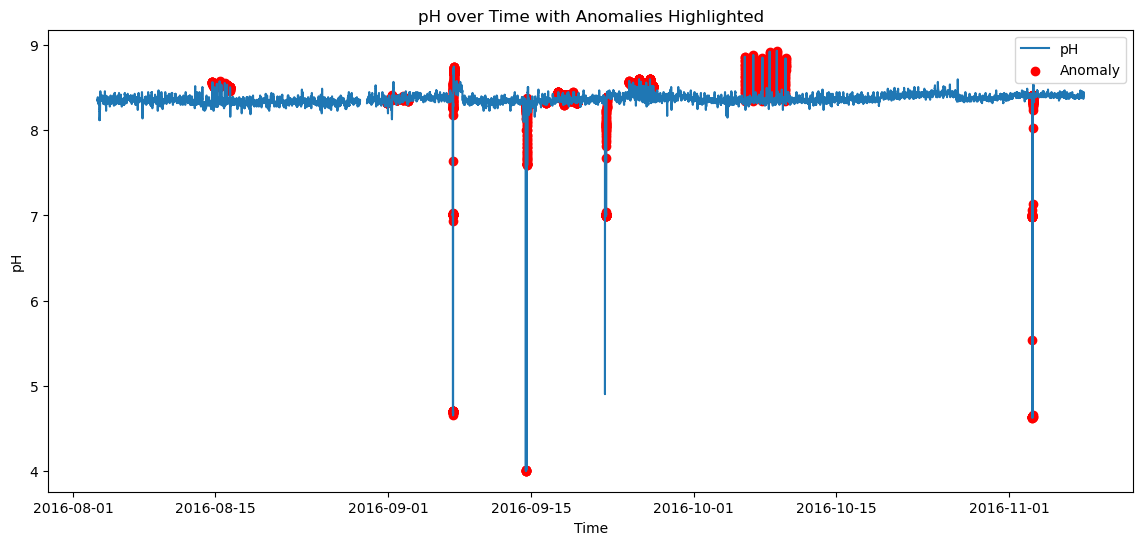

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['pH'], label='pH')
plt.scatter(anomalies['Time'], anomalies['pH'], color='red', label='Anomaly')
plt.title('pH over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('pH')
plt.legend()
plt.show()

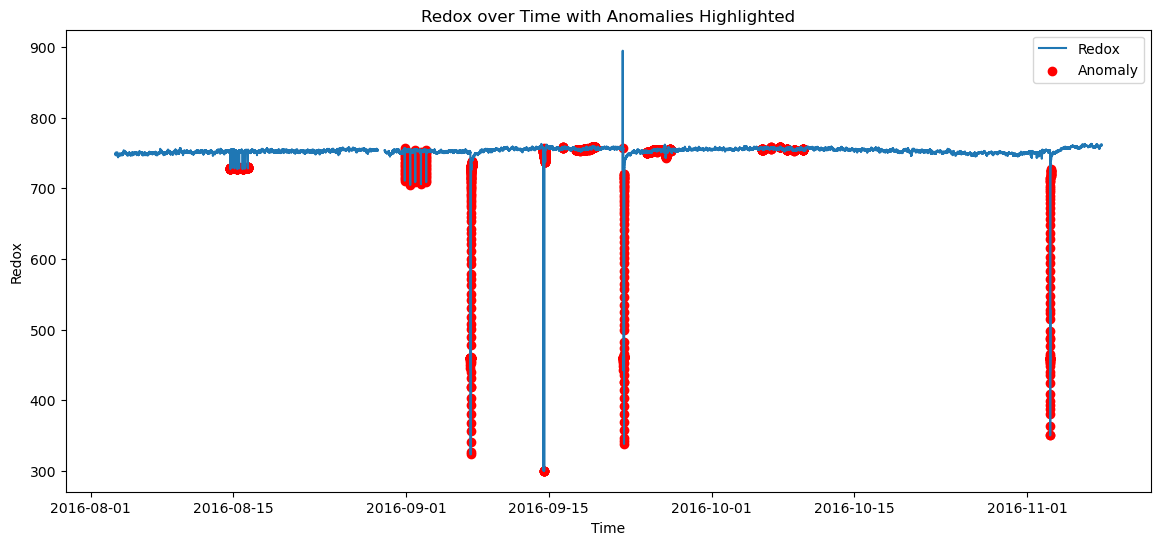

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Redox'], label='Redox')
plt.scatter(anomalies['Time'], anomalies['Redox'], color='red', label='Anomaly')
plt.title('Redox over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Redox')
plt.legend()
plt.show()

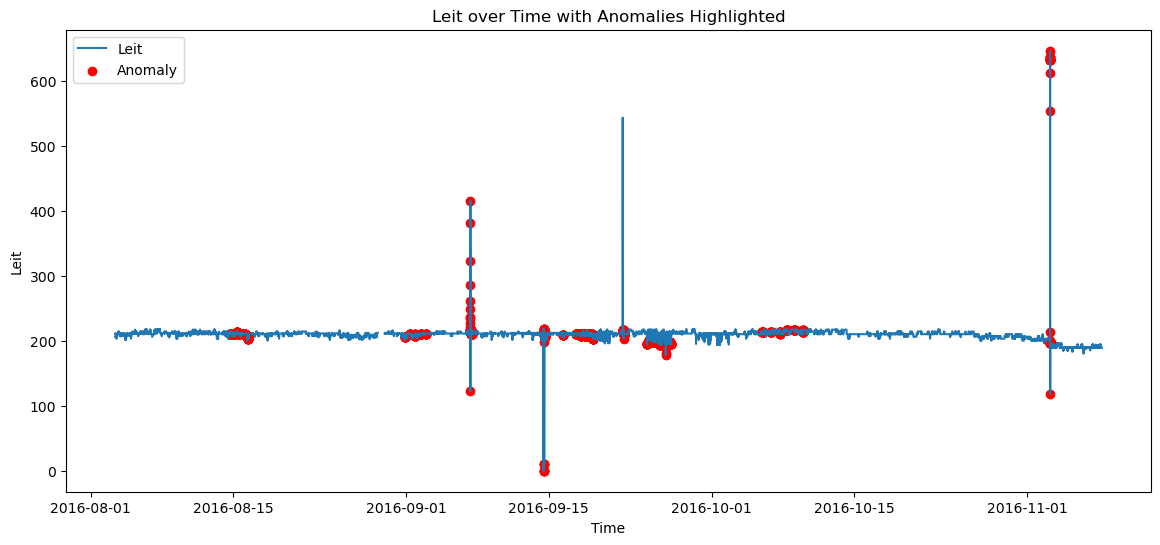

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Leit'], label='Leit')
plt.scatter(anomalies['Time'], anomalies['Leit'], color='red', label='Anomaly')
plt.title('Leit over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Leit')
plt.legend()
plt.show()

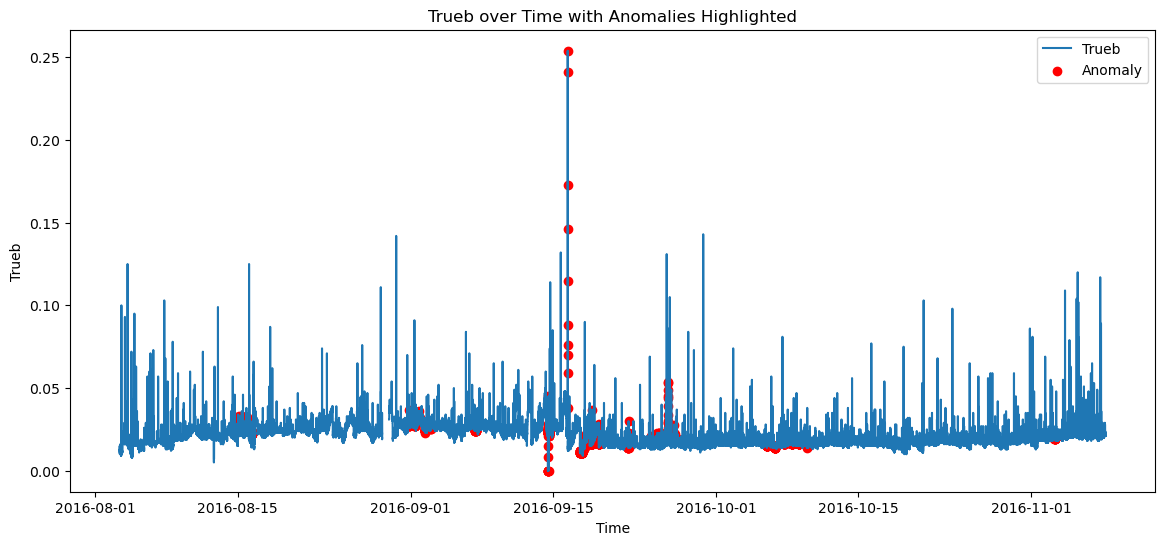

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Trueb'], label='Trueb')
plt.scatter(anomalies['Time'], anomalies['Trueb'], color='red', label='Anomaly')
plt.title('Trueb over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Trueb')
plt.legend()
plt.show()

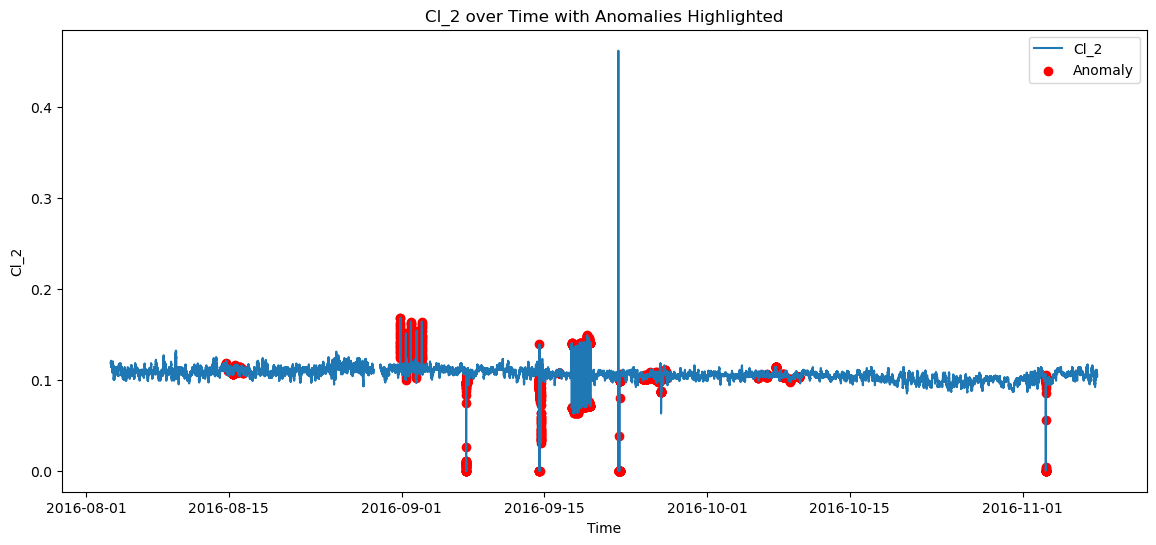

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Cl_2'], label='Cl_2')
plt.scatter(anomalies['Time'], anomalies['Cl_2'], color='red', label='Anomaly')
plt.title('Cl_2 over Time with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Cl_2')
plt.legend()
plt.show()

In [25]:
df.head()

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03 09:49:00+00:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,2016-08-03 09:50:00+00:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,2016-08-03 09:51:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,2016-08-03 09:52:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,2016-08-03 09:53:00+00:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


In [26]:
anomalies["Hour"] = anomalies["Time"].dt.hour

/var/folders/x9/wfxfy30n21j10t1dqkkhfjjm0000gn/T/ipykernel_7116/4114646678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies["Hour"] = anomalies["Time"].dt.hour


In [27]:
hourly_anomalies = anomalies.groupby("Hour").size()

In [28]:
hourly_anomalies_sorted = hourly_anomalies.sort_values(ascending=False)

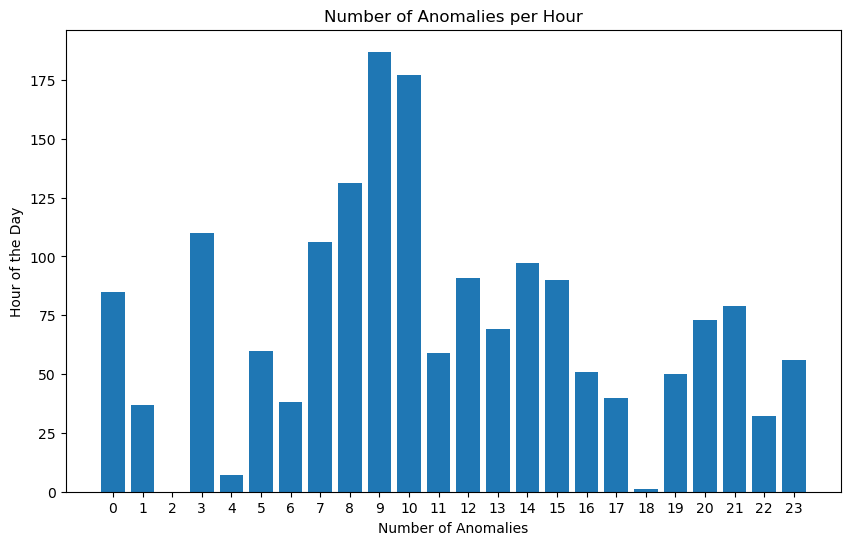

In [29]:
hours_per_day = list(range(24))

plt.figure(figsize=(10, 6))
plt.bar(hourly_anomalies_sorted.index, hourly_anomalies_sorted.values)
plt.xlabel('Number of Anomalies')
plt.ylabel('Hour of the Day')
plt.xticks(hours_per_day)
plt.title('Number of Anomalies per Hour')
plt.show()

Finally, from this graph it looks like anomalies are almost evenly distributed, except for 9 and 10 am where we have a pick of anomalies.